In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

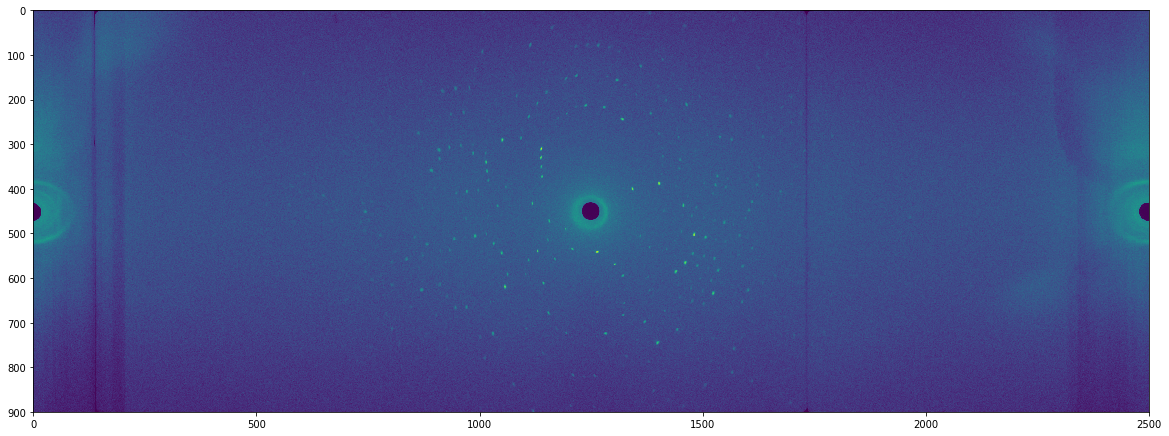

In [3]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.frame(0)))
plt.show()

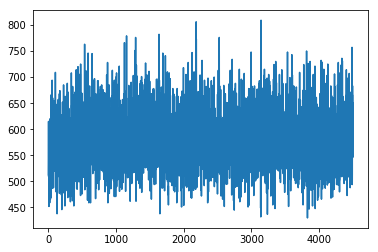

581.6302222222222
579.5


In [11]:
x0 = 600
y0 = 300
x1 = x0+30
y1 = y0+30

z0 = 100
z1 = z0+5

frames = [ data.frame(z)[y0:y1, x0:x1] for z in range(z0, z1)]
sample = np.array(frames).flatten()

plt.plot(sample)
plt.show()

print(sample.mean())
print(np.median(sample))

7869


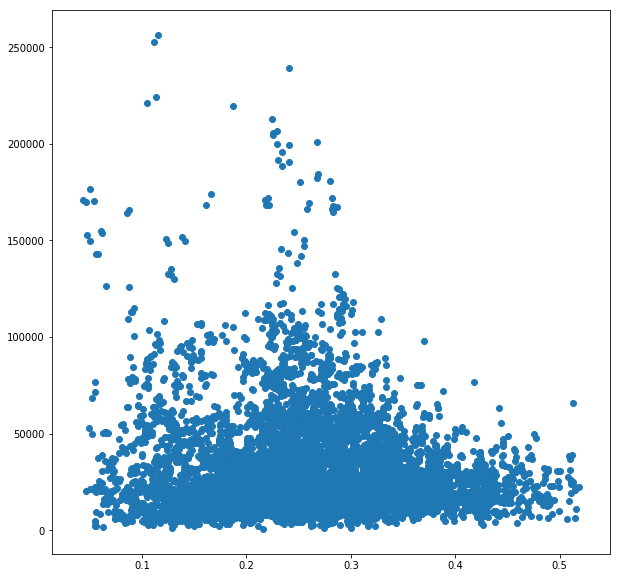

In [18]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.correctedIntensity().value()
    sigma = peak.correctedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.q().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [20]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.getSample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = nsx.MillerIndex(peak.q(), uc)
    if np.linalg.norm(hkl.error()) < 0.2:
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 7869 peaks
indexed 4966 of 7869
found unit cell with parameters: 
a:  54.90215864187893
b:  58.61276471561686
c:  67.22882798216096
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948966


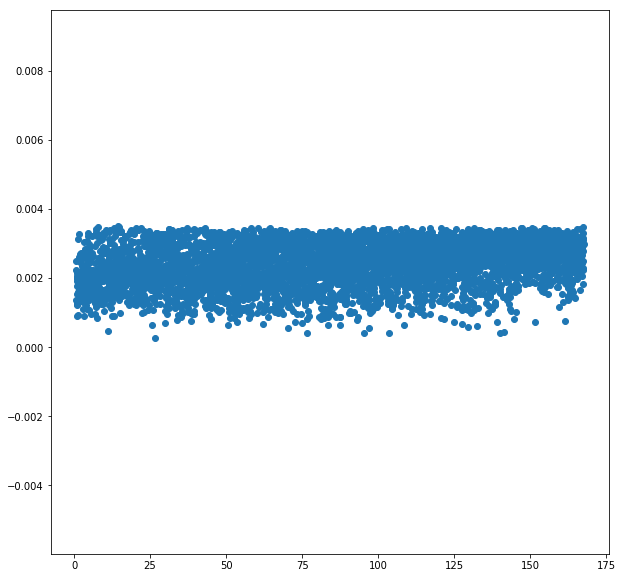

npred 4909


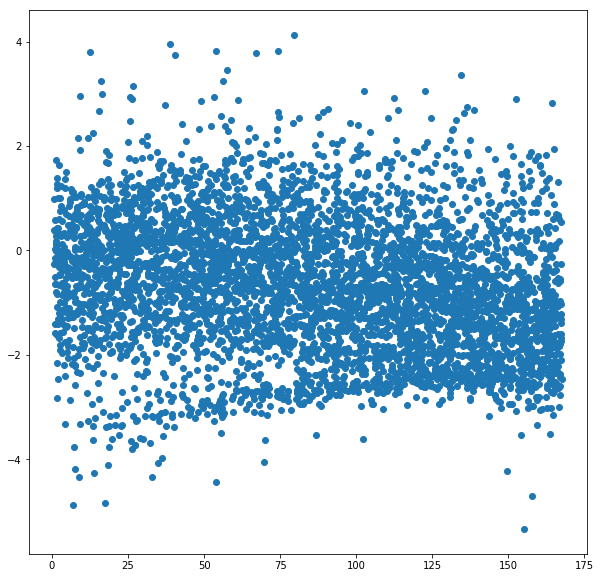

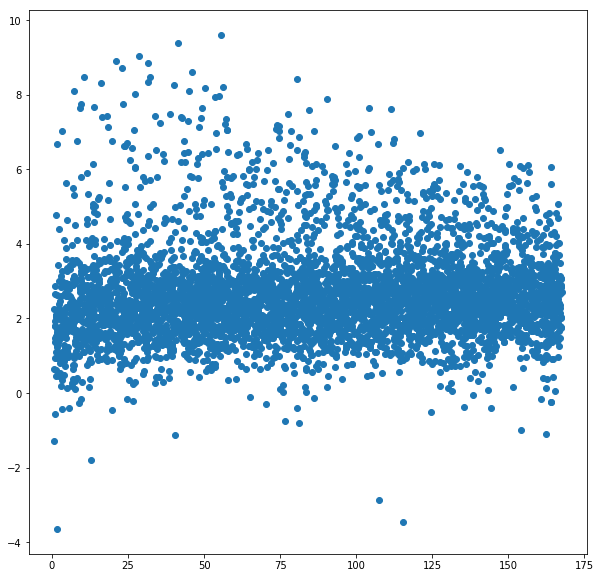

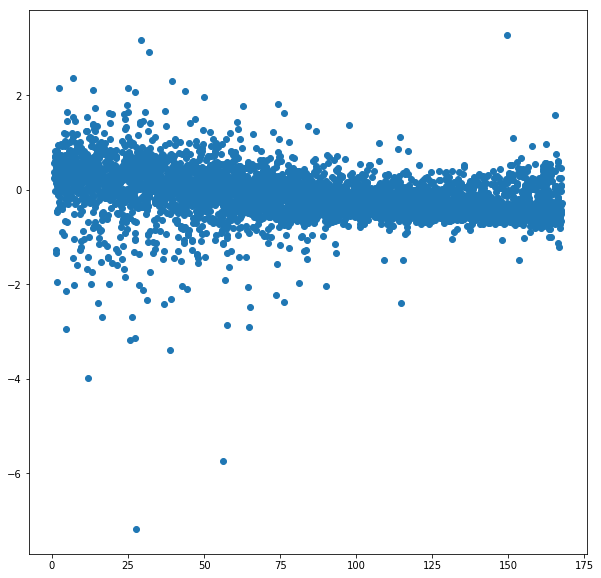

In [37]:
plot_dq_vs_frame(indexed_peaks)
plot_dx_vs_frame(indexed_peaks, 10)

In [38]:
nbatches = int(data.nFrames() / 5)
#nbatches = 1
states = data.instrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


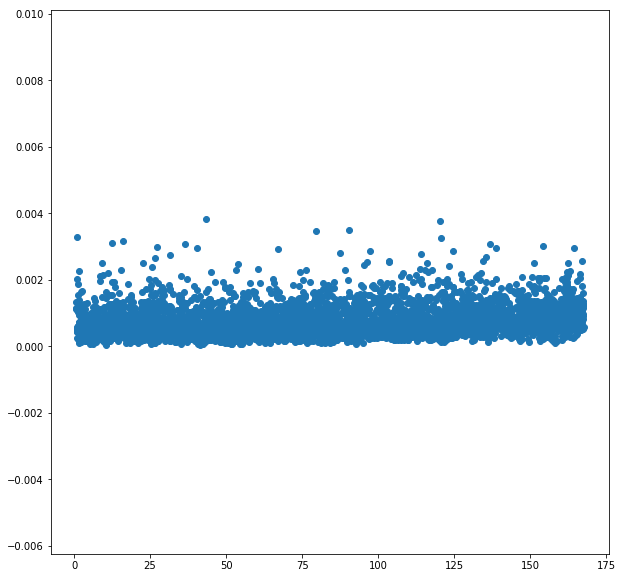

npred 4915


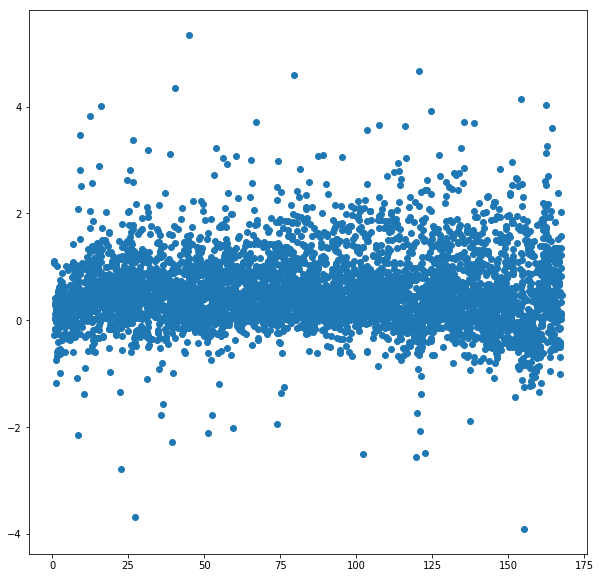

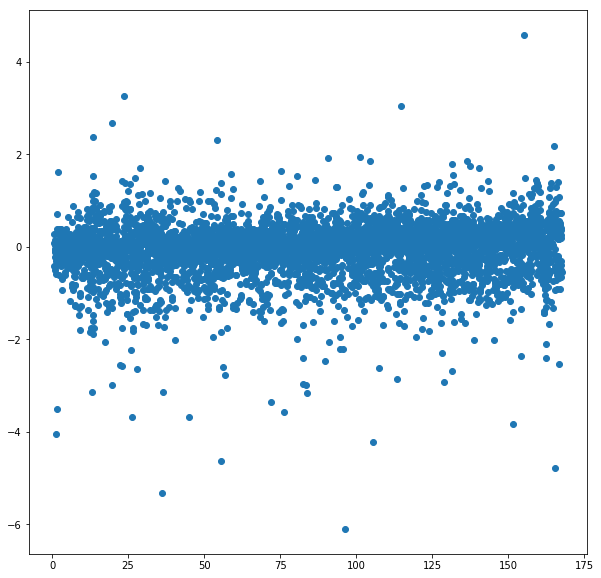

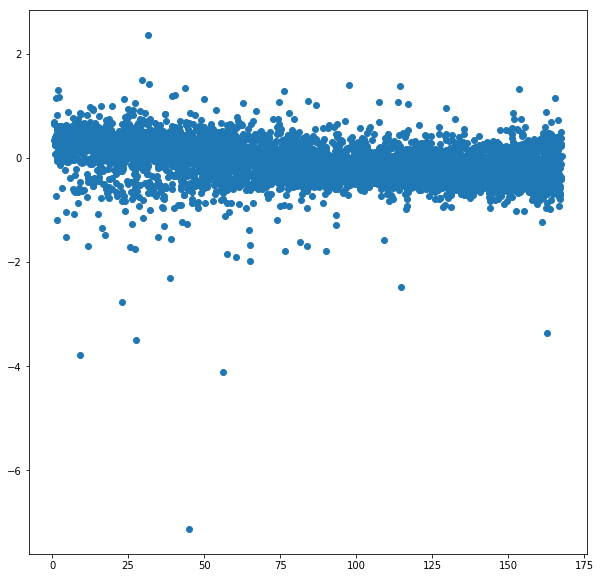

In [39]:
plot_dq_vs_frame(indexed_peaks)
plot_dx_vs_frame(indexed_peaks, 10)

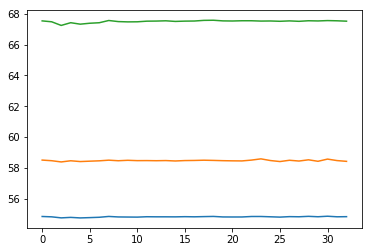

In [40]:
abc = []

for b in refiner.batches():
    ch = b.cell().character()
    abc.append([ch.a, ch.b, ch.c])
    
plt.plot([a[0] for a in abc])
plt.plot([a[1] for a in abc])
plt.plot([a[2] for a in abc])
plt.show()

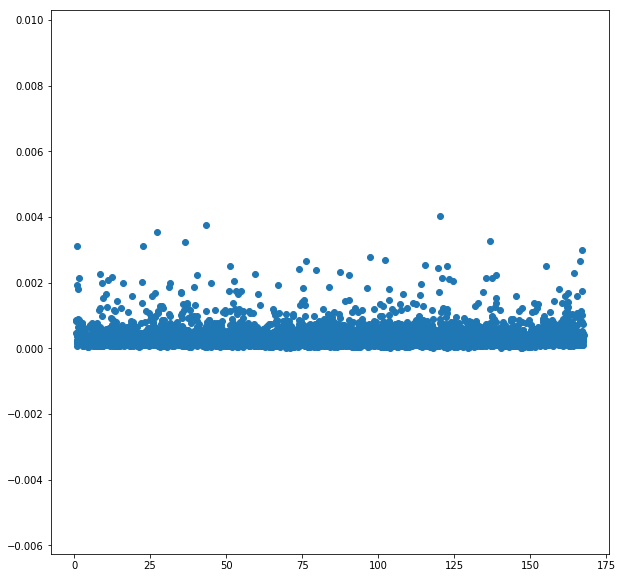

npred 4913


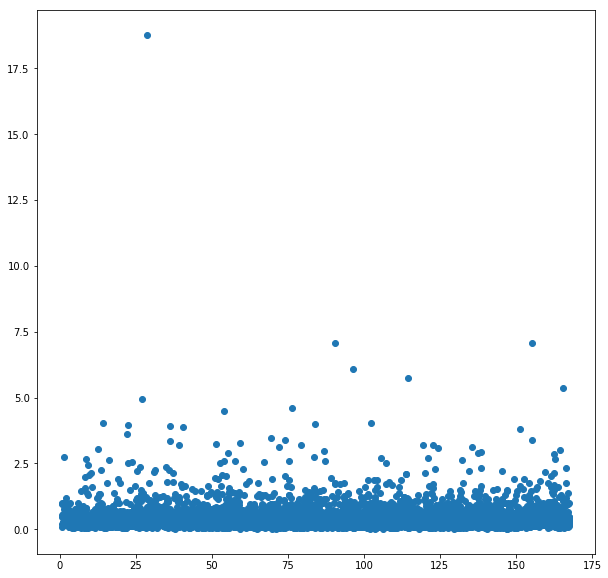

In [20]:
refined_peaks = reindex(indexed_peaks, refiner.batches())
plot_dq_vs_frame(refined_peaks)
plot_dx_vs_frame(refined_peaks)

sample position


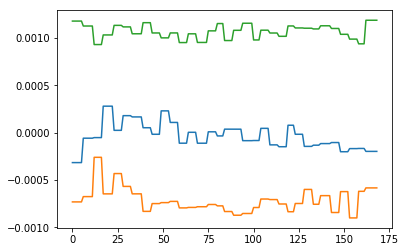

sample orientation perturbation


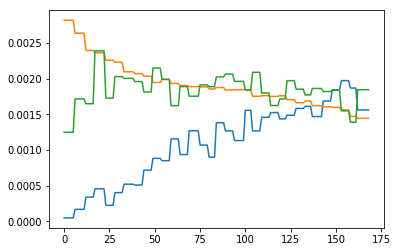

nx, nz


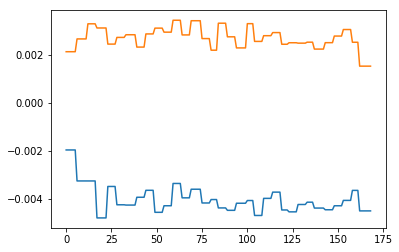

In [41]:
print("sample position")
plt.plot([state.samplePosition[0] for state in states])
plt.plot([state.samplePosition[1] for state in states])
plt.plot([state.samplePosition[2] for state in states])
plt.show()
    
print("sample orientation perturbation")
plt.plot([state.sampleOrientationOffset[0] for state in states])
plt.plot([state.sampleOrientationOffset[1] for state in states])
plt.plot([state.sampleOrientationOffset[2] for state in states])
plt.show()
    
print("nx, nz")
plt.plot([state.ni[0,0] for state in states])
#plt.plot([state.ni[0,1] for state in states])
plt.plot([state.ni[0,2] for state in states])
plt.show()

In [42]:
len(refined_peaks)
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

NameError: name 'refined_peaks' is not defined

In [24]:
#predicted = predict_peaks(data, refined_peaks)
#predicted.size()

In [25]:
data.integratePeaks(refined_peaks, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.992557868987288,
 'CCtrue': 0.9981307712166824,
 'Rmeas': 0.04767622884669591,
 'Rmerge': 0.03772424799574696,
 'Rpim': 0.028651393913760766}

In [26]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.diffractometer().getSource().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = nsx.MillerIndex(p.q(), bcell)
            
            if not hkl.indexed(0.2):
                continue
                
            hkl = hkl.rowVector()
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred
    
predicted = predict_peaks(refined_peaks, data, 1.5, 50.0, uc.reciprocalBasis(), refiner.batches())

In [27]:
data.integratePeaks(predicted, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9395745559844341,
 'CCtrue': 0.9842997672517815,
 'Rmeas': 0.21952221225389773,
 'Rmerge': 0.1775418518304442,
 'Rpim': 0.1261372264106694}

In [27]:
high_q = []

for p in predicted:
    q = np.linalg.norm(p.getQ().rowVector())
    d = 1 / q
    if d < 1.5 or d > 1.8:
        continue
        
    high_q.append(p)
    
print(len(high_q))
data.integratePeaks(high_q, 3.0, 5.0, nsx.ProgressHandler())
compute_statistics(high_q, nsx.SpaceGroup("P 21 21 21"), True)

17978


{'CChalf': 0.5686647514325999,
 'CCtrue': 0.8514871211902666,
 'Rmeas': 0.7265041806468173,
 'Rmerge': 0.5689231245991669,
 'Rpim': 0.4422687206632973}

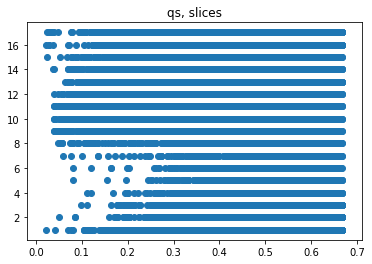

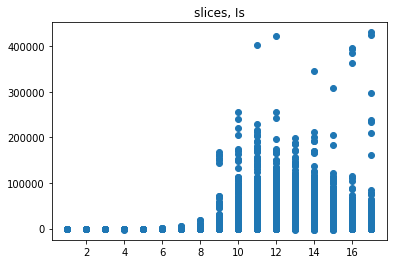

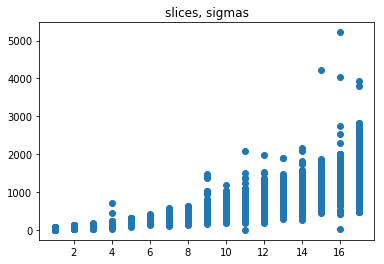

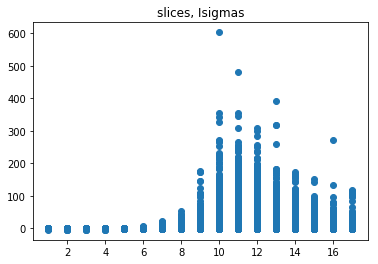

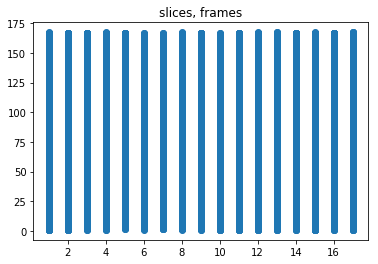

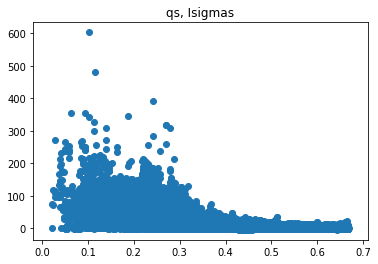

In [28]:
qs = []
slices = []
Is = []
sigmas = []
Isigmas = []
frames = []

for p in predicted:
    inten = p.correctedIntensity()
    isigma = inten.value() / (inten.sigma()+1e-6)
    
    #if (isigma > 1.0):
    #    continue

    frames.append(p.getShape().center()[2,0])
    Is.append(inten.value())
    sigmas.append(inten.sigma())
    Isigmas.append(inten.value() / (inten.sigma()+1e-6))
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    slices.append(p.getIntegrationRegion().bestSlice())
    
plt.scatter(qs, slices)
plt.title("qs, slices")
plt.show()

plt.scatter(slices, Is)
plt.title("slices, Is")
plt.show()

plt.scatter(slices, sigmas)
plt.title("slices, sigmas")
plt.show()

plt.scatter(slices, Isigmas)
plt.title("slices, Isigmas")
plt.show()

plt.scatter(slices, frames)
plt.title("slices, frames")
plt.show()

plt.scatter(qs, Isigmas)
plt.title("qs, Isigmas")
plt.show()

In [29]:
Isigmas

[17.28275062390933,
 26.927425011801574,
 21.49079310853227,
 6.551472753005099,
 53.469831610746496,
 50.784339470970565,
 20.95522095550475,
 11.74780385074873,
 -0.5382965422592105,
 68.86184558511675,
 15.429465954600284,
 4.0060173705988635,
 19.298052090192552,
 10.538836765935375,
 -0.9845577817679025,
 -1.1200471088807111,
 -0.11788408509596159,
 8.974963431347875,
 12.059354876875972,
 15.551916080409624,
 22.441006557611534,
 11.961814606203156,
 -0.019963148783136826,
 -0.02555670814091289,
 9.88030416635954,
 12.576932311356412,
 15.855358348331949,
 9.880513803314312,
 3.060237542407923,
 -0.060453078483276655,
 20.83184642922077,
 12.233387629350783,
 7.049569593448445,
 12.815709202320052,
 8.214227597070623,
 13.410951849770097,
 6.326427954595437,
 7.889820906461819,
 16.104595233318218,
 18.24061598634415,
 34.93793818629124,
 7.127390988174756,
 51.93570496903177,
 36.23349571982481,
 23.72619558950556,
 6.599996161147195,
 -0.8979025113889079,
 11.853256385806672,
 

In [42]:
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)


{'CChalf': 0.9407050433363285,
 'CCtrue': 0.9846048411245154,
 'Rmeas': 0.2150118409042321,
 'Rmerge': 0.1740688628772112,
 'Rpim': 0.12331145038224849}

In [29]:
strong_peaks = []

for p in predicted:
    inten = p.correctedIntensity()
    I = inten.value()
    sigma = inten.sigma()
    
    if sigma < 0.1:
        continue
        
    #if I / sigma < 0.5:
    #    continue
        
    strong_peaks.append(p)
    
print(len(strong_peaks))
compute_statistics(strong_peaks, nsx.SpaceGroup("P 21 21 21"), True)

55559


{'CChalf': 0.984874689746957,
 'CCtrue': 0.9961825712630379,
 'Rmeas': 0.15597465236593336,
 'Rmerge': 0.12485503243324825,
 'Rpim': 0.09151096857677887}

In [43]:
p = high_q[100]
region = p.getIntegrationRegion()
intgr = p.getIntegration()

shell_inten = intgr.shellIntensity()
shell_point = intgr.shellPoints()

In [30]:
bad = None

for p in high_q:
    inten = p.correctedIntensity()
    
    sigma = inten.sigma()
    I = inten.value()
    
    if sigma > 0.0 and I/sigma < -5.:
        bad = p
        break

NameError: name 'high_q' is not defined

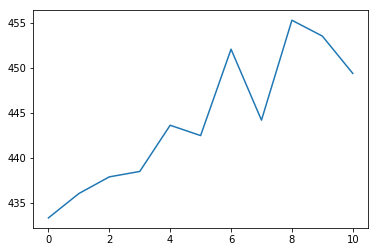

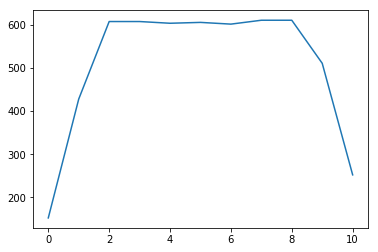

3


In [45]:
shell = p.getIntegration()

plt.plot(shell.shellIntensity() / shell.shellPoints())
plt.show()

plt.plot(shell.shellPoints())
plt.show()

print(p.getIntegrationRegion().bestSlice())

[[557.11059791  40.09831839 152.04277904]]
[[565.76881416  53.95919661 154.29697117]]


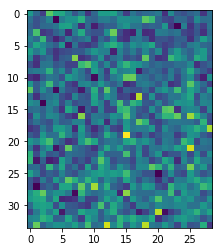

447.54868154158214


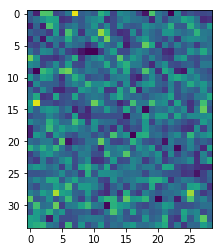

442.8346855983773


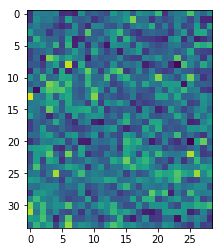

446.9127789046653


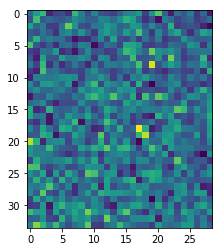

444.4553752535497


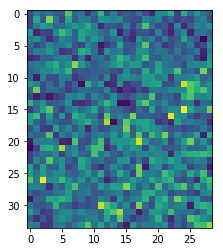

449.42190669371195


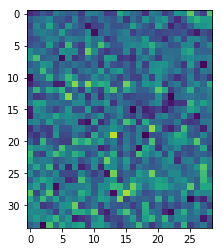

443.41379310344826


In [41]:
bb = p.getShape().aabb()
upper = bb.upper()
lower = bb.lower()

xmin = int(lower[0,0])
xmax = int(upper[0,0])
ymin = int(lower[1,0])
ymax = int(upper[1,0])
zmin = int(lower[2,0])
zmax = int(upper[2,0])

print(lower.transpose())
print(upper.transpose())

z = 0.5*(zmin+zmax)

expand=10

images = []

for i in range(-3, 3):
    image = data.frame(round(z)+i)
    image = image[ymin-expand:ymax+expand+1, xmin-expand:xmax+expand+1]
    plt.imshow(image, vmin=350, vmax=600)
    plt.show()
    print(image.mean())
    images.append(image)


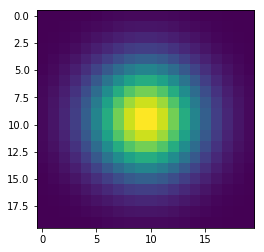

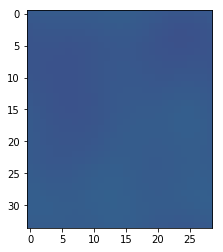

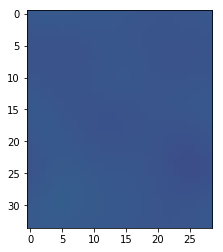

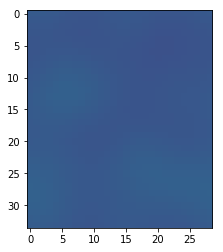

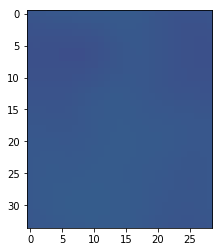

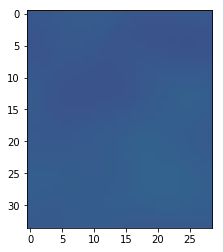

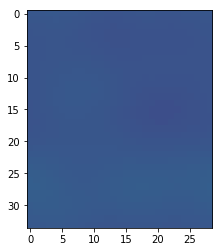

In [36]:
x = np.linspace(-3, 3, num=20)
x, y = np.meshgrid(x, x)
kernel = np.exp(-(x**2+y**2)/2.5)
kernel /= kernel.sum()
plt.imshow(kernel)
plt.show()

from scipy.signal import convolve2d

for image in images:
    conv = convolve2d(image, kernel, mode='same', boundary='wrap')
    plt.imshow(conv, vmin=350, vmax=700)
    plt.show()

In [37]:
image.max()
image.min()

322

In [38]:
def peak_volume(p):
    M = p.getShape().metric()
    return np.pi * 4 / 3.0 / np.sqrt(np.linalg.det(M))

In [31]:
nshells = 20
dmin = 1.5
dmax = 50.0

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

included = 0

for peak in predicted:
    inten = peak.correctedIntensity()
    I = inten.value()
    sigma = inten.sigma()
        
    if (sigma < 10.0):
        continue
        
    best_slice = peak.getIntegrationRegion().bestSlice()
        
    if best_slice < 4 or best_slice > 15:
        continue
        
    shells.addPeak(peak)
    included += 1
       
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
       
def print_stats():    
    print(" n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:4d} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f} {7:8.3f}"
        print(fmt.format(len(shells.shell(i)), d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

print("Total peaks", included)

 n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
 577    1.500    1.526    0.836    0.631    0.542    0.559    0.847
 761    1.526    1.554    0.822    0.610    0.544    0.480    0.805
 825    1.554    1.583    0.850    0.630    0.565    0.496    0.814
 841    1.583    1.616    0.594    0.437    0.400    0.743    0.923
 951    1.616    1.651    0.613    0.462    0.399    0.782    0.937
 944    1.651    1.689    0.659    0.491    0.435    0.634    0.881
 988    1.689    1.732    0.615    0.459    0.406    0.641    0.884
1017    1.732    1.778    0.554    0.407    0.373    0.686    0.902
1074    1.778    1.831    0.513    0.387    0.332    0.730    0.919
1086    1.831    1.890    0.469    0.353    0.304    0.806    0.945
1193    1.890    1.957    0.332    0.251    0.215    0.869    0.964
1147    1.957    2.036    0.333    0.250    0.218    0.852    0.959
1225    2.036    2.128    0.226    0.171    0.146    0.919    0.979
1281    2.128    2.241    0.309    0.237    0.1

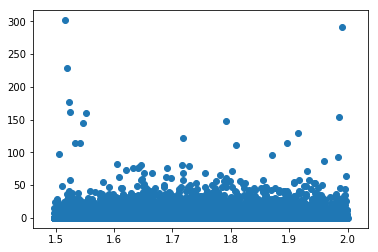

In [33]:
merged_data = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)
bad = None

for peak in predicted:
    if not peak.isSelected():
        continue
    
    inten = peak.correctedIntensity()
    if inten.sigma() < 1.0:
        continue
    
    merged_data.addPeak(peak)
    
ds = []
chis = []
        
for merged_peak in merged_data.getPeaks():
    chi2 = merged_peak.chi2()
    
    d = 1.0 / np.linalg.norm(merged_peak.getPeaks()[0].getQ().rowVector())
    
    if d > 2.0:
        continue
    
    ds.append(d)
    chis.append(chi2)
    
    if chi2 > 200:
        bad = merged_peak
    
plt.scatter(ds, chis)
plt.show()

In [ ]:
bad

In [34]:
def show_peak(p):
    bb = p.getShape().aabb()
    upper = bb.upper()
    lower = bb.lower()

    xmin = int(lower[0,0])
    xmax = int(upper[0,0])
    ymin = int(lower[1,0])
    ymax = int(upper[1,0])
    zmin = int(lower[2,0])
    zmax = int(upper[2,0])

    z = round(0.5*(zmin+zmax))

    expand=5
    
    print(lower.transpose(), upper.transpose())

    image = data.frame(z)
    image = image[ymin-expand:ymax+expand+1, xmin-expand:xmax+expand+1]
    plt.imshow(image)
    plt.show()


49250.985500218034 2834.0717342361113 1.5153347283169523
[[246.19577676  22.13446158  23.95263841]] [[268.99756916  37.56408242  27.95354199]]


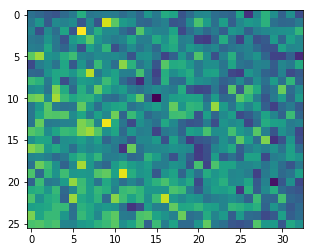

-6.106264397779747 90.59392697550804 1.5170536917071498
[[263.31130242  42.74593237  59.68239874]] [[283.15381747  57.01969716  63.21786617]]


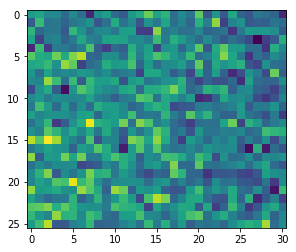

In [36]:
bad_peaks = [ p for p in bad.getPeaks() ]

for p in bad_peaks:
    inten = p.correctedIntensity()    
    d = 1.0 / np.linalg.norm(p.getQ().rowVector())
    print(inten.value(), inten.sigma(), d)
    show_peak(p)

In [ ]:
def distortion(p):
    A = np.linalg.inv(p.getShape().metric())
    return  np.power(np.linalg.det(A), 2/3.0) / ((A**2).trace() / 3)

In [ ]:
qs = []
ds = []
vs = []
rs = []
dists = []
lors = []

for p in predicted:
    if (p.getRawIntensity().sigma() < 1.0):
        continue
    
    v = peak_volume(p)
    vs.append(v)
    rs.append(np.power(v, 1/3.))
    q = np.linalg.norm(p.getQ().rowVector())
    qs.append(q)
    ds.append(1/q)
    dists.append(distortion(p))
    
    raw_inten = p.getRawIntensity().value()
    cor_inten = p.getCorrectedIntensity().value()
    lors.append(cor_inten/(raw_inten+1e-10))
    
plt.figure(figsize=(10,10))
plt.scatter(qs, dists, s=5.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(qs, vs, s=1.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(qs, lors, s=5.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(dists, lors, s=5.0)
plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(ds, rs, s=1.0)
#plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(qs, rs, s=1.0)
#plt.show()


In [ ]:
small_ds = []
small_lor = []

for i in range(len(ds)):
    if ds[i] > 2.0:
        continue
        
    small_ds.append(ds[i])
    small_lor.append(lors[i])
    
plt.scatter(small_ds, small_lor)
plt.show()

In [ ]:
print(np.min(lors))
print(np.max(lors))

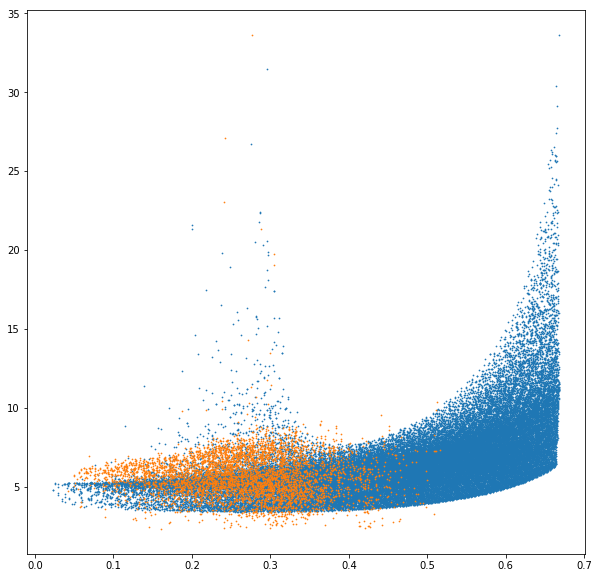

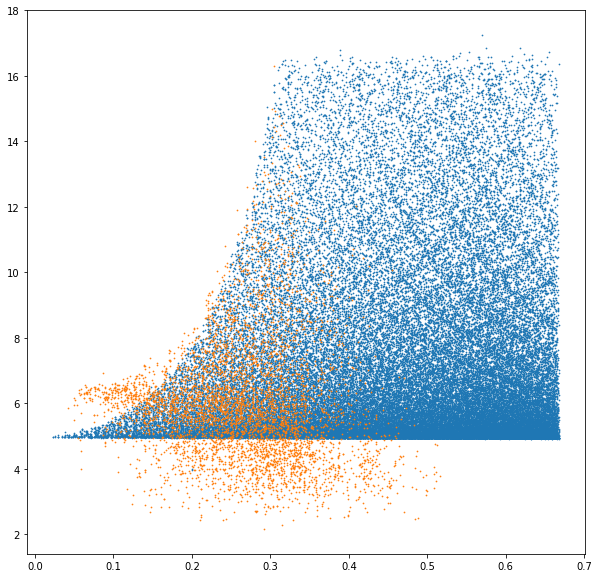

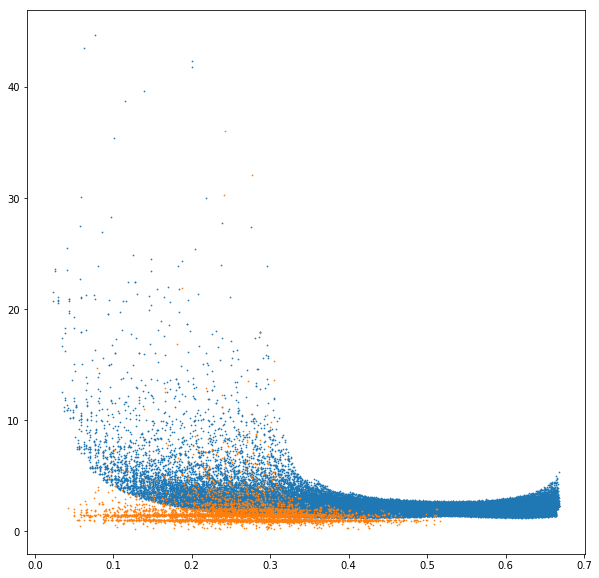

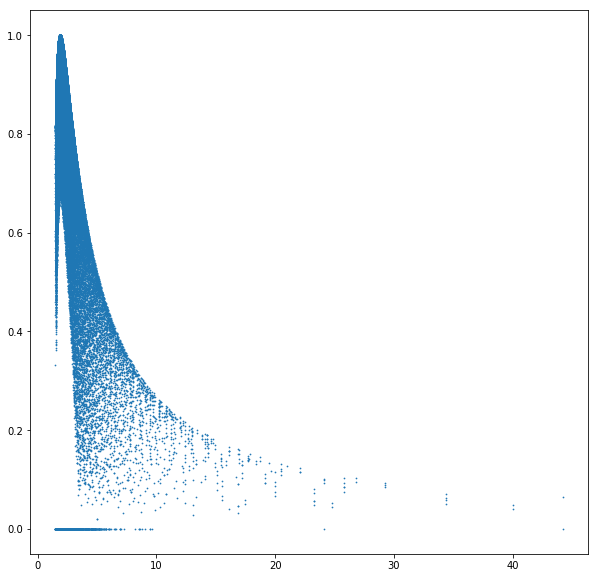

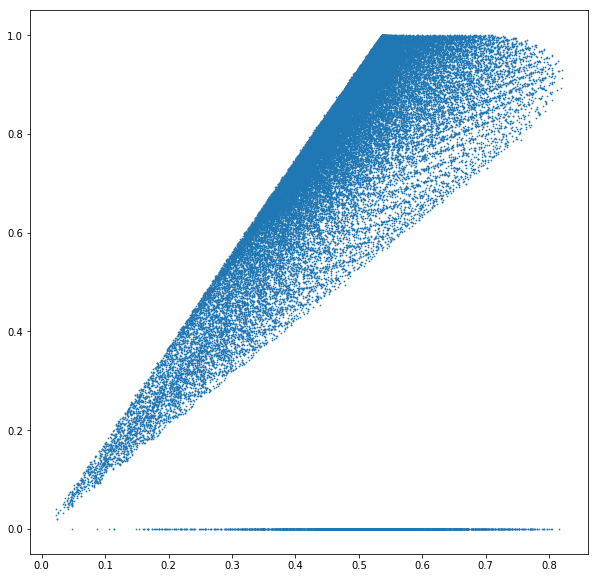

In [37]:
qs = []
xs = []
ys = []
zs = []


pred_qs = []
pred_xs = []
pred_ys = []
pred_zs = []

pred_lor = []

for p in refined_peaks:
    
    bb = p.getShape().aabb()
    dx = bb.upper() - bb.lower()
    
    if (np.linalg.norm(dx) > 50):
        continue
    
    xs.append(dx[0,0])
    ys.append(dx[1,0])
    zs.append(dx[2,0])
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    

for p in predicted:
    
    bb = p.getShape().aabb()
    dx = bb.upper() - bb.lower()
    
    if (np.linalg.norm(dx) > 50):
        continue
    
    pred_xs.append(dx[0,0])
    pred_ys.append(dx[1,0])
    pred_zs.append(dx[2,0])
    pred_qs.append(np.linalg.norm(p.getQ().rowVector()))
    
    if p.getRawIntensity().value() != 0:
        pred_lor.append(p.correctedIntensity().value() / p.getRawIntensity().value())
    else:
        pred_lor.append(0.0)

    #eps = 1e-2
   # if (dx[1,0] < 5+eps and dx[1,0]>5-eps):
      #  print(dx)

scale = 0.5

plt.figure(figsize=(10,10))
plt.scatter(pred_qs, pred_xs, s=scale)
plt.scatter(qs, xs, s=scale)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(pred_qs, pred_ys, s=scale)
plt.scatter(qs, ys, s=scale)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(pred_qs, pred_zs, s=scale)
plt.scatter(qs, zs, s=scale)
plt.show()


plt.figure(figsize=(10,10))
plt.scatter(1.0 / np.array(pred_qs), pred_lor, s=scale)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(1.0 / np.array(pred_zs), pred_lor, s=scale)
plt.show()



In [46]:
nshells = 20
dmin = 1.5
dmax = 50.0

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

num_good = 0

for peak in predicted:
    
    inten = peak.correctedIntensity()
    
    if (inten.sigma() <= 0):
        continue
        
    #if (inten.value() / inten.sigma() < 0.1):
    #    continue
                
    bb = peak.getShape().aabb()
    dx = bb.upper()-bb.lower()
    
    dx = np.linalg.norm(dx)    
    if dx > 2000:
        continue
        
    # detector plates
    c = peak.getShape().center()
    
    if c[0,0] > 1720 and c[0,0] < 1750:
        continue
    
    shells.addPeak(peak)
    num_good += 1
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
   
def print_stats():    
    print("   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:8.3f} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f}"
        print(fmt.format(d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()
print(num_good)

   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
   1.500    1.526    0.918    0.679    0.611    0.352    0.722
   1.526    1.554    0.807    0.610    0.520    0.439    0.781
   1.554    1.583    0.733    0.562    0.462    0.653    0.889
   1.583    1.616    0.675    0.521    0.422    0.633    0.880
   1.616    1.651    0.744    0.580    0.457    0.591    0.862
   1.651    1.689    0.613    0.478    0.378    0.708    0.911
   1.689    1.732    0.586    0.461    0.355    0.719    0.915
   1.732    1.778    0.572    0.450    0.347    0.701    0.908
   1.778    1.831    0.483    0.383    0.288    0.792    0.940
   1.831    1.890    0.458    0.363    0.274    0.790    0.939
   1.890    1.957    0.361    0.288    0.213    0.880    0.968
   1.957    2.036    0.340    0.268    0.205    0.869    0.964
   2.036    2.128    0.309    0.248    0.182    0.888    0.970
   2.128    2.241    0.281    0.223    0.167    0.887    0.969
   2.241    2.381    0.238    0.185    0.148    0.905 

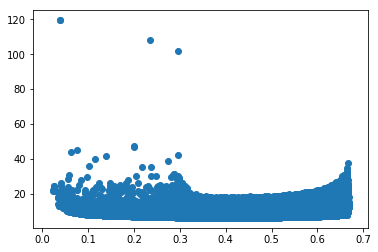

In [47]:
qs = []
dxs = []

for peak in predicted:
    
    
   

                
    bb = peak.getShape().aabb()
    dx = bb.upper()-bb.lower()
    
    dx = np.linalg.norm(dx) 
    
    if dx > 1500:
        continue
    
    qs.append(np.linalg.norm(peak.getQ().rowVector()))
    dxs.append(dx)
    
plt.scatter(qs, dxs)
plt.show()

In [48]:
really_bad = []

for peak in predicted:
    inten = peak.correctedIntensity()
    
    if (inten.sigma() <= 0.0):
        continue
        
    Isigma = inten.value() / inten.sigma()
    
    if inten.sigma() < 30.0:
        #bb = peak.getShape().aabb()
        #print(bb.upper().transpose(), bb.lower().transpose())
        #print(inten.value(), inten.sigma())
       # print(1.0 / np.linalg.norm(peak.getQ().rowVector()))
        #print("--------------------------------")
        
        really_bad.append(peak)
        
print(len(really_bad))

529


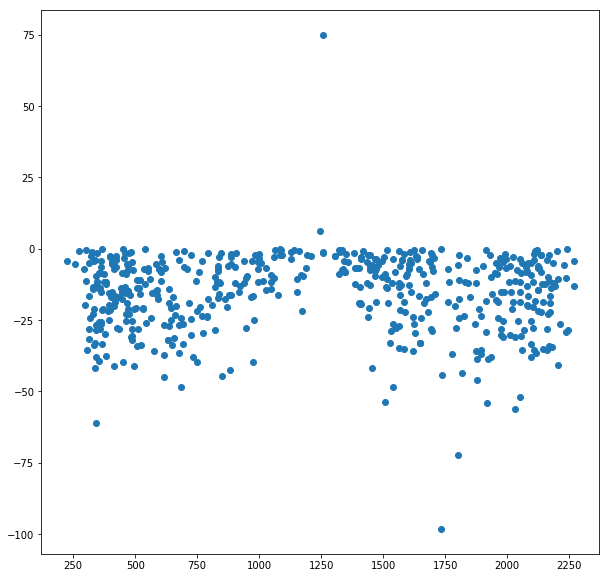

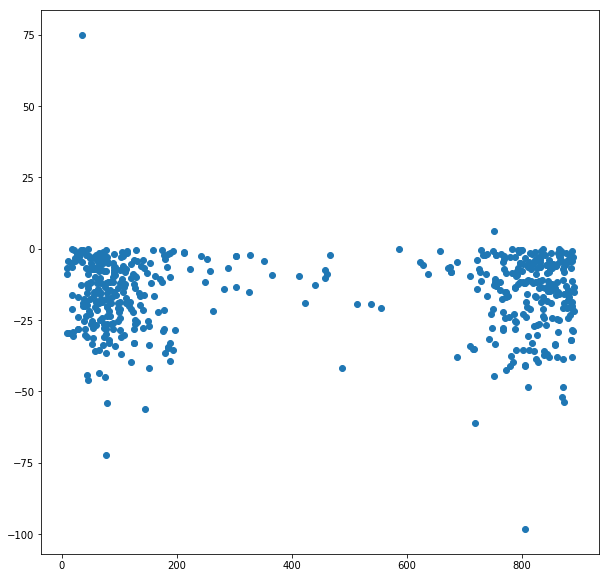

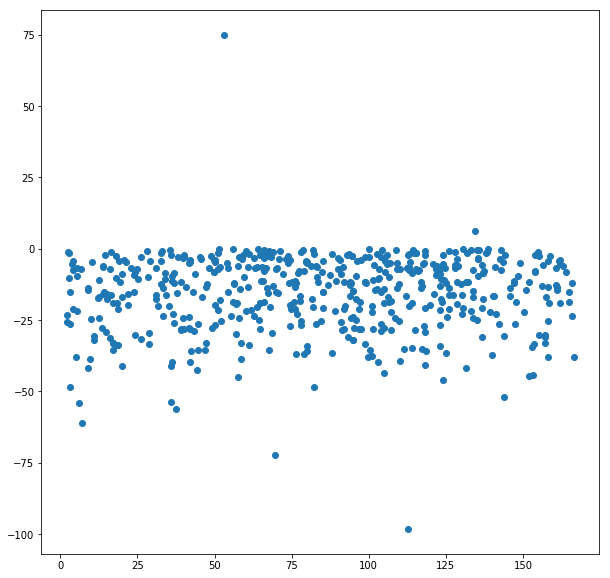

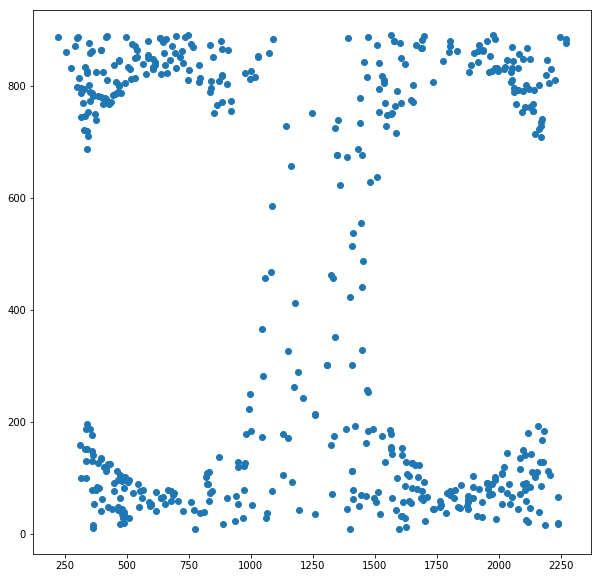

In [49]:
qs = []
xs = []
ys = []
zs = []
Is = []
sigmas = []

for peak in really_bad:

    qs.append(np.linalg.norm(peak.q().rowVector()))
    
    bb = peak.getShape().aabb()
    c = peak.getShape().center()
    
    xs.append(c[0,0])
    ys.append(c[1,0])
    zs.append(c[2,0])
    
    inten = peak.correctedIntensity()
    sigmas.append(inten.sigma())    
    Is.append(inten.value())
    

    
plt.figure(figsize=(10,10))
plt.scatter(xs, Is)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(ys, Is)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(zs, Is)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(xs, ys)
plt.show()


In [ ]:
xs

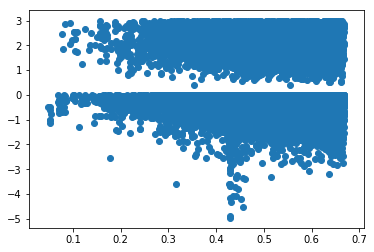

In [50]:
qs = []
Isigmas = []

for p in predicted:
    
    
    inten = p.correctedIntensity()
    
    if inten.sigma() <= 0:
        continue
        
    
    Isigma = inten.value() / inten.sigma()
    
    if Isigma > 3.0:
        continue
    
    qs.append(np.linalg.norm(p.q().rowVector()))
    Isigmas.append(Isigma)
    
    
plt.scatter(qs, Isigmas)
plt.show()

In [82]:
import random

bad_peaks = []

for p in predicted:
    inten = p.correctedIntensity()
    
    if inten.sigma() <= 0:
        continue
        
    Isigma = inten.value() / inten.sigma()
    
    if Isigma > 0 or Isigma < -1.5:
        continue
    
    bad_peaks.append(p)

In [83]:
bad = random.sample(bad_peaks, 1)[0]
inten = bad.correctedIntensity()
print(inten.value(), inten.value()/inten.sigma())

-54.35090893091905 -0.2586597865282548


[570.58514201 606.51412841  23.07601144]
[[574.01811885 609.55809844  24.07181715]] [[567.15216516 603.47015837  22.08020573]]
[1.71648842 1.52198502 0.49790286]
[559, 596, 19] [582, 617, 27]


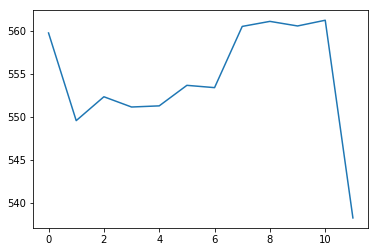

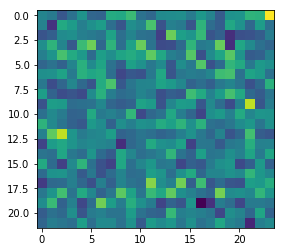

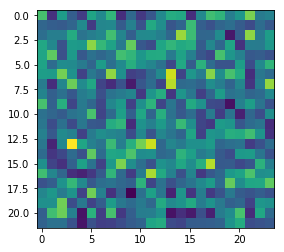

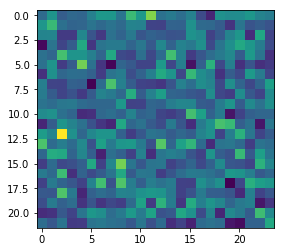

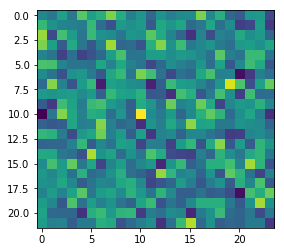

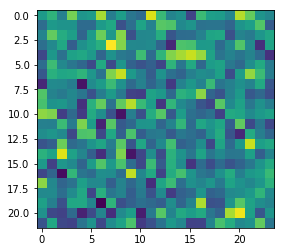

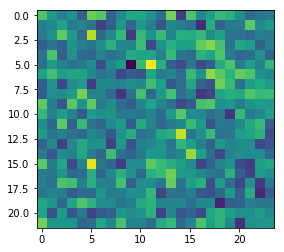

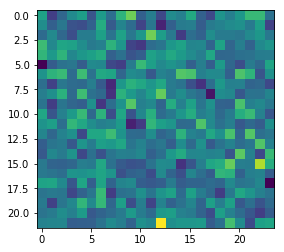

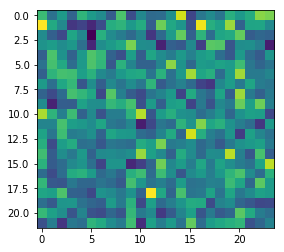

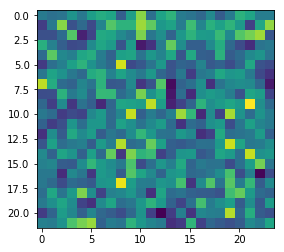

In [84]:
c = bad.getShape().center().reshape(3)
bb = bad.getShape().aabb()

ub = bb.upper().reshape(3)
lb = bb.lower().reshape(3)

print(c.transpose())
print(bb.upper().transpose(), bb.lower().transpose())

ub = ub.reshape(3)
lb = lb.reshape(3)

dx = 0.5*(ub-c)
print(dx)

lb = [ int(round(-6*dx[i]+c[i])-1) for i in range(3) ]
ub = [ int(round(6*dx[i]+c[i])+1) for i in range(3) ]

print(lb, ub)

integral = bad.getIntegration()
region = bad.getIntegrationRegion()

avg = integral.shellIntensity() / integral.shellPoints()

plt.plot(avg)
plt.show()

frames = []

for z in range(lb[2], ub[2]+1):
    image = data.frame(z)[lb[1]:ub[1]+1, lb[0]:ub[0]+1]
    frames.append(image)
    plt.imshow(image)
    plt.show()

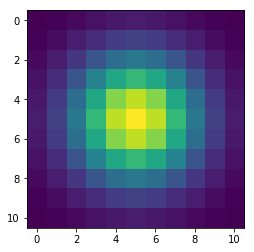

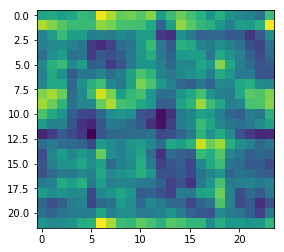

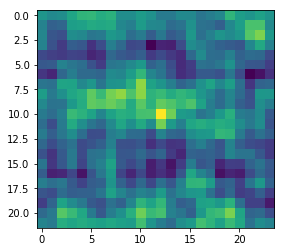

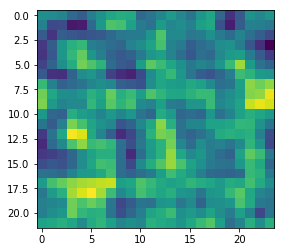

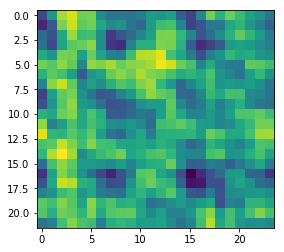

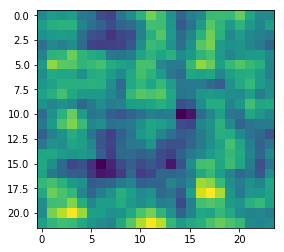

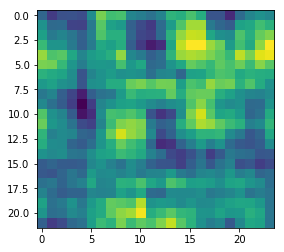

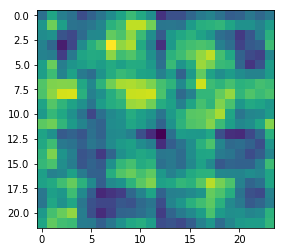

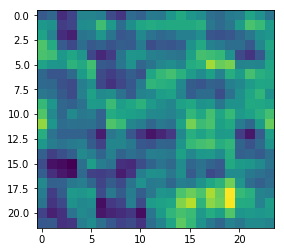

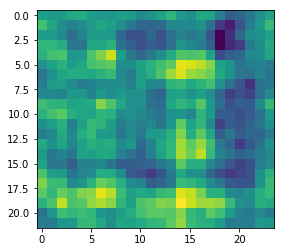

In [85]:
from scipy.signal import convolve2d

width = 11
height = 11

x = np.linspace(0, width, num=width) - width/2
y = np.linspace(0, height, num=height) - height/2
x, y = np.meshgrid(x, y)

kernel = np.exp(-0.5*(x**2+y**2)/6)
kernel /= kernel.sum()

plt.imshow(kernel)
plt.show()

kernel = np.roll(kernel, round(width/2), axis=0)
kernel = np.roll(kernel, round(height/2), axis=1)

for frame in frames:
    conv = convolve2d(frame, kernel, mode='same', boundary='wrap')
    plt.imshow(conv)
    plt.show()

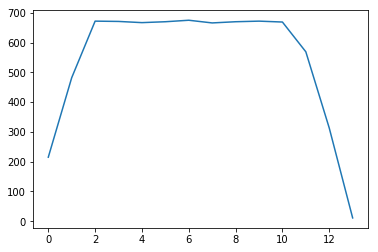

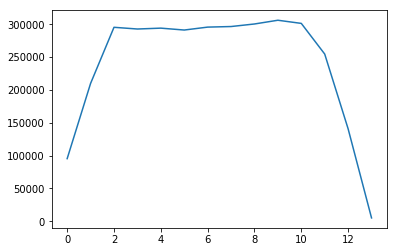

In [68]:
plt.plot(integral.shellPoints())
plt.show()

plt.plot(integral.shellIntensity())
plt.show()

In [88]:
pred = nsx.PeakPredictor(data)
qshape = pred.averageQShape(predicted)

In [90]:
np.linalg.eig(qshape)

(array([520685.48311663, 167803.80117634, 184796.21199037]),
 array([[ 0.23906026, -0.96525636, -0.10550045],
        [-0.9704058 , -0.241314  ,  0.00895175],
        [ 0.03409947, -0.10023824,  0.99437896]]))